In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

# joblib for loading saved model from Part 2
# Did not work - SEE BELOW
# from joblib import load

In [2]:
# Set the Year for the data to use
YEAR = 2017

# Read data into dataframes
train_features = pd.read_csv('data/' + str(YEAR) + '/training_features_' + str(YEAR) + '.csv')
test_features = pd.read_csv('data/' + str(YEAR) + '/testing_features_' + str(YEAR) + '.csv')
train_labels = pd.read_csv('data/' + str(YEAR) + '/training_labels_' + str(YEAR) + '.csv')
test_labels = pd.read_csv('data/' + str(YEAR) + '/testing_labels_' + str(YEAR) + '.csv')

In [3]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
# Load the model from Part 2
#   This did NOT work. MAE with model read back in = 64 (should be ~9)
#   Why is this? Investigate later. Training time savings.
# model = load('final_model.joblib')

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Peformance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Peformance on the test set: MAE = 8.9699


In [7]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.556368
1,Weather Normalized Site Electricity Intensity ...,0.165003
2,Largest Property Use Type_Non-Refrigerated War...,0.046350
3,log_Water Intensity (All Water Sources) (gal/ft²),0.040832
4,Property Id,0.038404
5,Order,0.027705
6,DOF Gross Floor Area,0.025588
7,log_Direct GHG Emissions (Metric Tons CO2e),0.024572
8,Largest Property Use Type_Multifamily Housing,0.020361
9,Year Built,0.020060


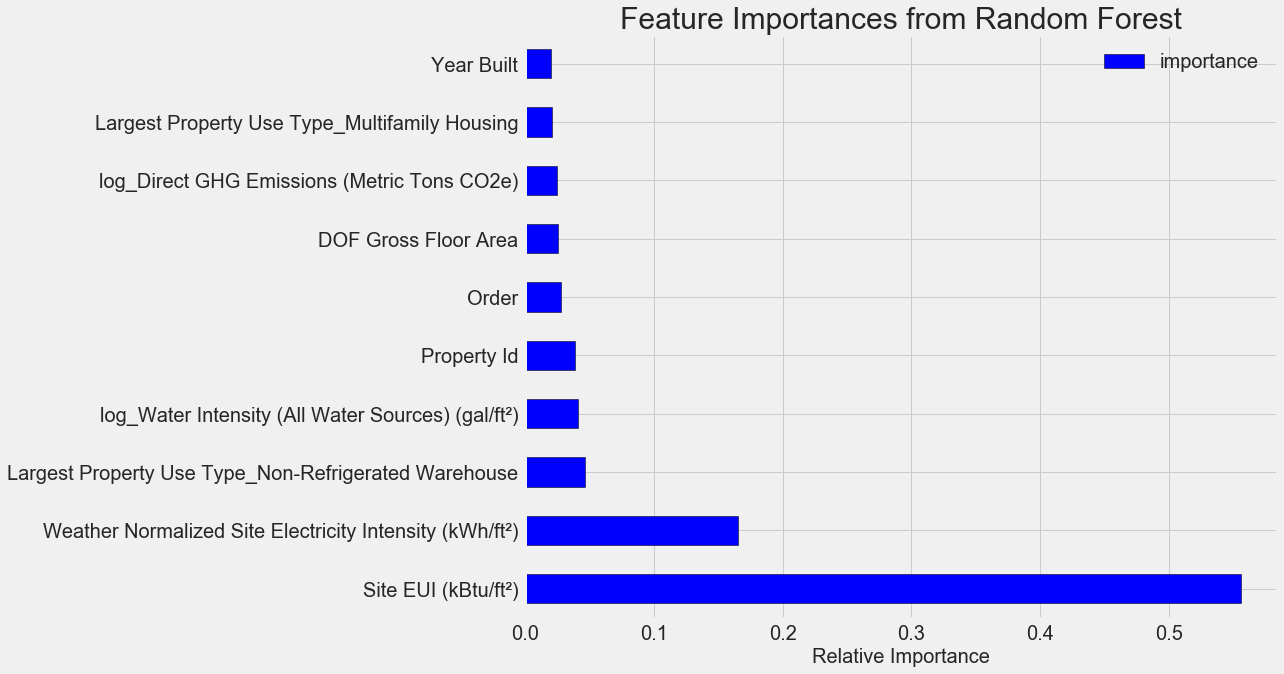

In [8]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature',
                                y = 'importance', 
                                edgecolor = 'k',
                                kind='barh',
                                color = 'blue');
plt.xlabel('Relative Importance', size = 20);
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

In [9]:

# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [10]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.6391.
Linear Regression Reduced Results: MAE = 14.3521.


In [11]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad',
                                          max_depth=5,
                                          max_features=None,
                                          min_samples_leaf=6,
                                          min_samples_split=6, 
                                          n_estimators=800,
                                          random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.3695


In [12]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [13]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 11.2703
Actual Value: 94.0000


C:\Users\ahenders\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.387338e-27
  overwrite_a=True).T


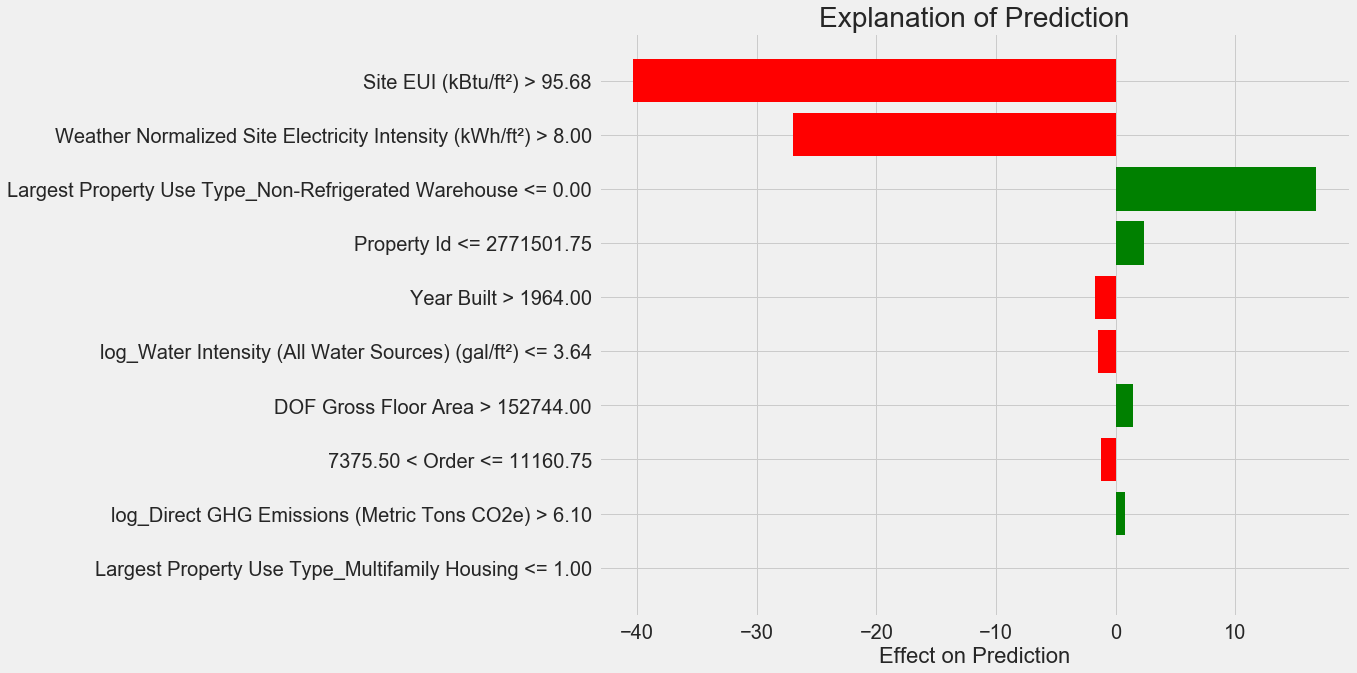

In [14]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [15]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Prediction: 99.9967
Actual Value: 100.0000


C:\Users\ahenders\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.265019e-27
  overwrite_a=True).T


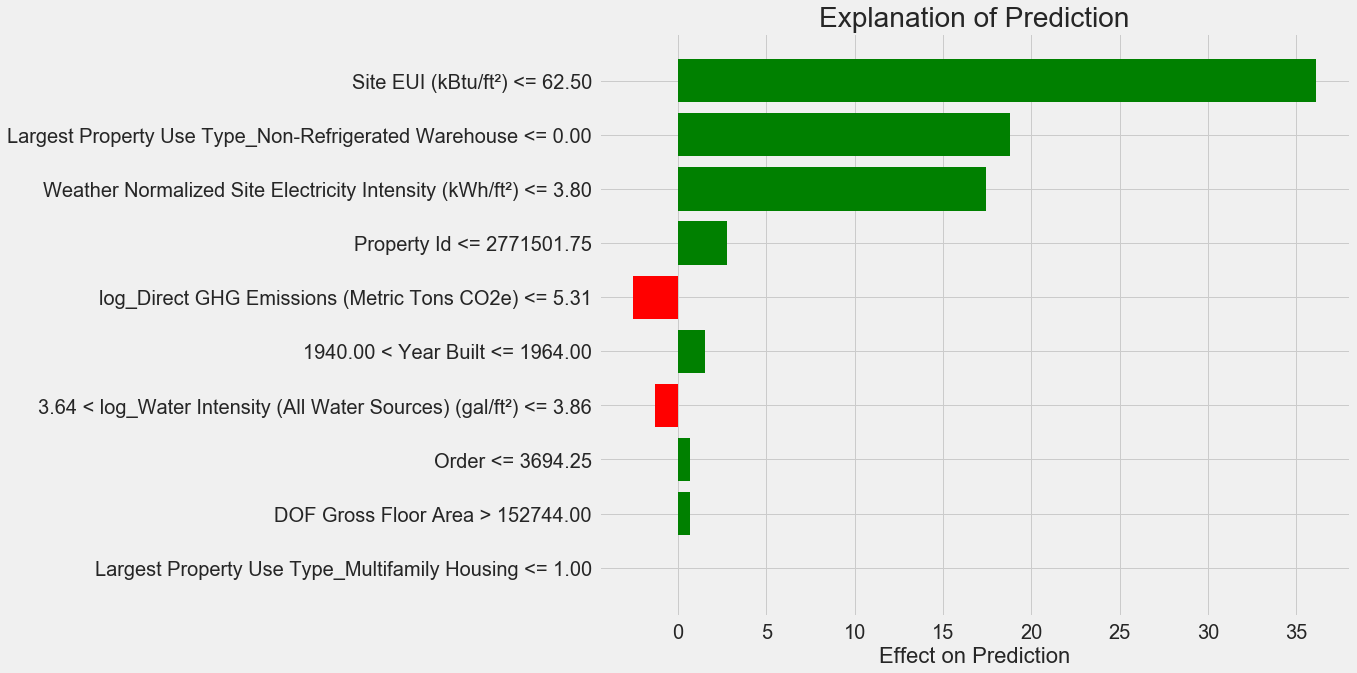

In [16]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [17]:
right_exp.show_in_notebook(show_predicted_value=False)

In [19]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree,
                     out_file = 'images/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=6,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x000002BA2E7DF558>,
           splitter='best')

In [20]:
tree.export_graphviz(single_tree,
                     out_file = 'images/tree_small.dot',
                     rounded = True,
                     feature_names = most_important_features,
                     filled = True,
                     max_depth = 3)

In [27]:
# THIS PART DID NOT WORK
# import graphviz
# from subprocess import check_call
# import pydot

# check_call(['dot', '-Tpng', './images/tree.dot', '-o', './images/tree.png'])
# check_call(['dot', '-Tpng', './images/tree_small.dot', '-o', './images/tree_small.png'])
# (graph,) = pydot.graph_from_dot_file('images/tree.dot')
# graph.write_png('images/tree.png')

FileNotFoundError: [WinError 2] "dot" not found in path.